# SVM  y Multiple Testing
En este trabajo se trabajará con una base de datos que cuenta con 83 muestras y 2308 variables. La variable de salida cuenta con valores numéricos del 1 al 4 que corresponde a diferentes tipos de cáncer. La idea es hacer tanto un análisis de prueba de hipótesis para poder ver cuales expresiones genéticas tienen una mayor importancia estadística en el tipo de cáncer. Además de hacer tres modelos de clasificación con Support Vector Machines para poder observar que tipos de kernel funcionan mejor. 

Primero se va a importar la base de datos y se revisará si hay datos vacíos. 


In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests 

df  = pd.read_csv("A3.1 Khan.csv")

print(df.shape)
#la siguiente linea se genero con ayuda de chatgpt
#añade una columna que incluye la cantidad de huecos que tiene cada fila
df["DatosVacios"] = df.isnull().sum(axis=1)
print(df.DatosVacios.value_counts())
df.drop("DatosVacios",axis=1,inplace=True)




(83, 2309)
DatosVacios
0    83
Name: count, dtype: int64


Afortunadamente, no hay datos vacíos por lo que no es necesario imputar datos.

Ahora, se encontrarán los 10 genes con mayores diferencias entre las categorías 2 y 4. En un análisis de inferencia se buscaría demostrar que la diferencia entre las medias de estos genes es estadísticamente significativa para poder utilizarlos como ayuda para clasificar tipos de cáncer. Al tener una diferencia de medias mayor, las expresiones de estos genes son mejores para diferenciar entre tumores de clase 2 y clase 4. 



In [39]:
#Separar por clases 

class1 = df[df["y"] == 1]
class2 = df[df["y"] == 2]
class3 = df[df["y"]==3]
class4 = df[df["y"]==4]


print("Tamaño clase 2")
class2Mean = class2.mean(axis=0).drop('y')
class4Mean = class4.mean(axis=0).drop('y')


differences = np.abs(class2Mean-class4Mean)


LargestDifferences  =pd.DataFrame( differences.nlargest(10))


print(LargestDifferences.head(10))

Tamaño clase 2
              0
X187   3.323151
X509   2.906537
X2046  2.424515
X2050  2.401783
X129   2.165185
X1645  2.065460
X1319  2.045941
X1955  2.037340
X1003  2.011337
X246   1.837830


Ahora que se tienen las 10 variables con mayor diferencia de promedio se van a hacer múltiples pruebas de hipótesis para ver cuáles son las variables que tienen importancia estadística. 

Estas pruebas de hipótesis se harán con el estadístico T de student, con la hipótesis nula de que el promedio de cada variable entre ambas muestras es igual para las dos categorías. 

Para esto se utilizará la función multipletests de statsmodels.stats.multitest. A cada gen se le hizo una prueba de hipótesis y todo se juntó en un DataFrame.

Después de eso, se ajustaron los errores para evitar falsos descubrimientos. Se compararán los resultados de utilizar tres metodologías diferentes, metodología de Bonferroni, de Holm y de Benjamini Hochberg. 


In [40]:
import scipy.stats 
ttest = scipy.stats.ttest_ind(class2Mean,class4Mean)
print(ttest)


ttestValues  = []
pValues = []
degreesFreedom = []
genName = []
tempT = 0 
tempP = 0
for gen in class2.columns :
    tempT, tempP = scipy.stats.ttest_ind(class2[gen],class4[gen])
    ttestValues.append(tempT)
    pValues.append(tempP)
    genName.append(gen)

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

pValuesd = {'Gen':genName, 'T':ttestValues,'PValues':pValues}
pValuesDF = pd.DataFrame(pValuesd)

print(pValuesDF.head())





# for i in range(0 , 83 , 1) :
#         tempT, tempP = scipy.stats.ttest_ind(class2Mean[i],class4Mean[i])
#         ttestValues.append(tempT)
#         pValues.append(tempP)

# print(ttestValues)
# print(pValues)


TtestResult(statistic=-1.0713622538753331, pvalue=0.2840626139251289, df=4614.0)
  Gen         T       PValues
0  X1  0.737187  4.643217e-01
1  X2 -7.247278  1.996254e-09
2  X3  4.300195  7.527096e-05
3  X4 -0.230214  8.188286e-01
4  X5  1.114639  2.701303e-01


c:\Users\ethan\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
print(pValuesDF.PValues.shape)

##Definir valores corregidos
#Metodo de Bonferroni
correctedBonferroni = multipletests(pValuesDF.PValues, alpha=0.05, method = 'bonferroni')
#Método de Holm
correctedHolm = multipletests(pValuesDF.PValues, alpha = 0.05, method = 'holm')
#Método de Benjamini Hochberg
correctedBH = multipletests(pValuesDF.PValues, alpha = 0.05, method = 'fdr_bh')

#Añadir al DF 
pValuesDF["Results Bonferroni"] = correctedBonferroni[0]
pValuesDF["PValues Bonferroni"] = correctedBonferroni[1]

pValuesDF["Results Holm"] = correctedHolm[0]
pValuesDF["PValues Holm"] = correctedHolm[1]

pValuesDF["Results Benjamini/Hochberg"] = correctedBH[0]
pValuesDF["PValues Benjamini/Hochberg"] = correctedBH[1]




(2309,)


In [42]:
#Imprimir resultados de método de bonferroni
print("Cantidad de Genes con diferencias significativas metodología de Bonferroni")

print(pValuesDF[pValuesDF["Results Bonferroni"]==True].shape[0])

print("Genes con diferencias significativas Bonferroni")
print(pValuesDF[pValuesDF["Results Bonferroni"]==True].Gen)


# Imprimir resultados metodología de Holm
print("Cantidad de Genes con diferencias significativas metodología de Holm")

print(pValuesDF[pValuesDF["Results Holm"]==True].shape[0])

print("Genes con diferencias significativoa Holm")
print(pValuesDF[pValuesDF["Results Holm"]==True].Gen)

#Imprimir resultados metodología Benjamini-Hochberg
print("Cantidad de Genes con diferencias significativas metodología de Benjamini - Hochberg")

print(pValuesDF[pValuesDF["Results Benjamini/Hochberg"]==True].shape[0])

print("Genes significativos Benjamini/Hochberg")
print(pValuesDF[pValuesDF["Results Benjamini/Hochberg"]==True].Gen)


Cantidad de Genes con diferencias significativas metodología de Bonferroni
75
Genes con diferencias significativas Bonferroni
1          X2
35        X36
66        X67
128      X129
173      X174
        ...  
2145    X2146
2226    X2227
2246    X2247
2302    X2303
2308        y
Name: Gen, Length: 75, dtype: object
Cantidad de Genes con diferencias significativas metodología de Holm
75
Genes con diferencias significativoa Holm
1          X2
35        X36
66        X67
128      X129
173      X174
        ...  
2145    X2146
2226    X2227
2246    X2247
2302    X2303
2308        y
Name: Gen, Length: 75, dtype: object
Cantidad de Genes con diferencias significativas metodología de Benjamini - Hochberg
298
Genes significativos Benjamini/Hochberg
1          X2
2          X3
28        X29
35        X36
51        X52
        ...  
2294    X2295
2299    X2300
2300    X2301
2302    X2303
2308        y
Name: Gen, Length: 298, dtype: object


Ahora se hará un ANOVA unidireccional. Esto prueba la hipótesis nula de que dos o más grupos comparten la media. 
Primero se van a separar por clases los genes que quedan (de manera similar a como se hizo con las clases 2 y 4) después se hará el ANOVA utilizando la función f_oneway para cada gen. Finalmente, se hará la corrección de pvalues con metodología de Bonferroni, de Holm y de Benjamini Hochberg. 


In [43]:
from scipy.stats import f_oneway

tempF = 0
tempPANOVA = 0
fstatisticValues = []
pValuesANOVA = []
genName = []
for gen in class1.columns :
    tempF, tempPANOVA = f_oneway(class1[gen],class2[gen],class3[gen],class4[gen])
    pValuesANOVA.append(tempPANOVA)
    fstatisticValues.append(tempF)
    genName.append(gen)

anovad = {'Gen':genName,'F':fstatisticValues,'PAnova':pValuesANOVA}
anovaDF = pd.DataFrame(anovad) 
print(anovaDF.head())

  Gen          F        PAnova
0  X1  59.118264  3.839240e-20
1  X2  31.279175  1.977997e-13
2  X3  13.099869  5.004749e-07
3  X4   0.797322  4.990053e-01
4  X5   2.447098  6.989127e-02


c:\Users\ethan\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [44]:

##Definir valores corregidos
#Metodo de Bonferroni
correctedBonferroni = multipletests(anovaDF.PAnova, alpha=0.05, method = 'bonferroni')
#Método de Holm
correctedHolm = multipletests(anovaDF.PAnova, alpha = 0.05, method = 'holm')
#Método de Benjamini Hochberg
correctedBH = multipletests(anovaDF.PAnova, alpha = 0.05, method = 'fdr_bh')

#Añadir al DF 
anovaDF["Results Bonferroni"] = correctedBonferroni[0]
anovaDF["PValues Bonferroni"] = correctedBonferroni[1]

anovaDF["Results Holm"] = correctedHolm[0]
anovaDF["PValues Holm"] = correctedHolm[1]

anovaDF["Results Benjamini/Hochberg"] = correctedBH[0]
anovaDF["PValues Benjamini/Hochberg"] = correctedBH[1]



In [45]:
#Imprimir resultados de método de bonferroni
print("Resultados Anova")
print("Cantidad de Genes con diferencias significativas metodología de Bonferroni")

print(anovaDF[anovaDF["Results Bonferroni"]==True].shape[0])

print("Genes con diferencias significativas Bonferroni")
print(anovaDF[anovaDF["Results Bonferroni"]==True].Gen)


# Imprimir resultados metodología de Holm
print("Cantidad de Genes con diferencias significativas metodología de Holm")

print(anovaDF[anovaDF["Results Holm"]==True].shape[0])

print("Genes con diferencias significativoa Holm")
print(anovaDF[anovaDF["Results Holm"]==True].Gen)

#Imprimir resultados metodología Benjamini-Hochberg
print("Cantidad de Genes con diferencias significativas metodología de Benjamini - Hochberg")

print(anovaDF[anovaDF["Results Benjamini/Hochberg"]==True].shape[0])

print("Genes significativos Benjamini/Hochberg")
print(anovaDF[anovaDF["Results Benjamini/Hochberg"]==True].Gen)


Resultados Anova
Cantidad de Genes con diferencias significativas metodología de Bonferroni
405
Genes con diferencias significativas Bonferroni
0          X1
1          X2
2          X3
16        X17
28        X29
        ...  
2298    X2299
2300    X2301
2302    X2303
2303    X2304
2308        y
Name: Gen, Length: 405, dtype: object
Cantidad de Genes con diferencias significativas metodología de Holm
413
Genes con diferencias significativoa Holm
0          X1
1          X2
2          X3
16        X17
28        X29
        ...  
2298    X2299
2300    X2301
2302    X2303
2303    X2304
2308        y
Name: Gen, Length: 413, dtype: object
Cantidad de Genes con diferencias significativas metodología de Benjamini - Hochberg
1163
Genes significativos Benjamini/Hochberg
0          X1
1          X2
2          X3
8          X9
11        X12
        ...  
2300    X2301
2301    X2302
2302    X2303
2303    X2304
2308        y
Name: Gen, Length: 1163, dtype: object


Ya que se exploraron los datos y pudimos observar cuales son las variables estadísticamente significativas para cada caso propuesto, se procederá a entrenar varios modelos de support vector machines. 

Para evitar largos tiempos de procesamiento y overfitting se reducirán las variables de entrada utilizando los resultados anteriormente encontrados.

Ahora, esto es una práctica inadecuada que lleva a fuga de datos. Este trabajo es un ejercicio en clase con motivos educativos, por eso se procederá así, pero lo ideal sería un proceso de selección de características que solamente se base en experimentos realizados con los datos de entrenamiento. 

Consideraré 10 variables basadas en las que tengan un p-value menor para el ejercicio de ANOVA con método de Bonferroni. Esta es una idea que me dio chat-gpt, aunque el código es mío con el apoyo de las siguientes páginas.

https://saturncloud.io/blog/how-to-sort-pandas-dataframe-from-one-column/

https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy



In [46]:

##Sortear las variables por PValues de menor a mayor
anovaDF = anovaDF.sort_values("PValues Bonferroni", ascending= True)


#Crear una lista que contenga los nombres de los genes (coinciden con los nombres usados en las columnas)
# del data frame original.

Variables = anovaDF.head(11).Gen.tolist()

#Crear un data frame sólo con las variables de interés
dfForSVM = df[Variables]



Ya que se tiene la base de datos, se procederá a separar datos de entrenamiento y prueba. 

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Y = dfForSVM.y
X = dfForSVM.drop('y',axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, stratify=Y,random_state=10)




Ya con los datos separados se van a generar tres modelos de Support Vector Machines. El primero va a ser con un kernel lineal, el segundo va a ser con un kernel polinomial de tercer grado y el tercero con un kernel radial.
Después se muestran las matrices de confusión y valores de precisión, sensibilidad y valor de f1score. 

Kernel Lineal
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      0.89      0.94         9
           3       1.00      1.00      1.00         5
           4       0.89      1.00      0.94         8

    accuracy                           0.96        25
   macro avg       0.97      0.97      0.97        25
weighted avg       0.96      0.96      0.96        25



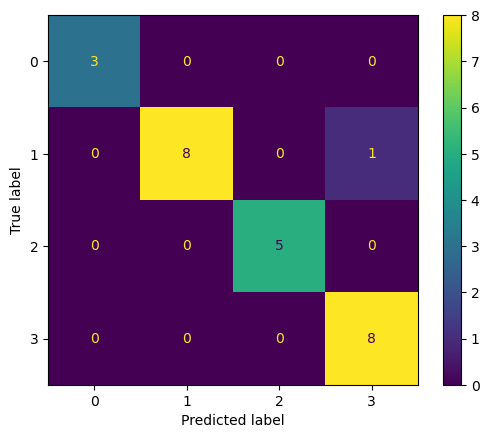

Kernel Polinomial
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      0.89      0.94         9
           3       1.00      0.80      0.89         5
           4       0.80      1.00      0.89         8

    accuracy                           0.92        25
   macro avg       0.95      0.92      0.93        25
weighted avg       0.94      0.92      0.92        25



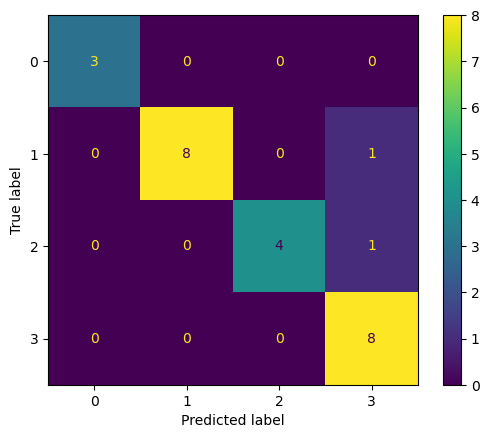

Kernel Radial
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      0.89      0.94         9
           3       1.00      1.00      1.00         5
           4       0.89      1.00      0.94         8

    accuracy                           0.96        25
   macro avg       0.97      0.97      0.97        25
weighted avg       0.96      0.96      0.96        25



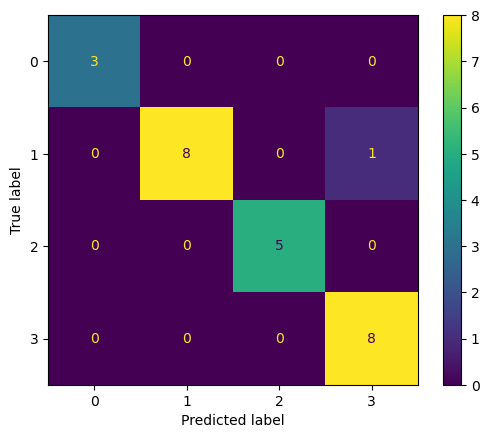

In [48]:
#Kernel lineal
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Kernel Lineal")
linealModel = SVC(kernel = 'linear').fit(X_train,Y_train)
yhat = linealModel.predict(X_test)
print(classification_report(Y_test,yhat))
ConfusionMatrixDisplay(confusion_matrix(Y_test,yhat)).plot()
plt.show()

print("Kernel Polinomial")
polyModel = SVC(kernel = 'poly',degree = 3).fit(X_train,Y_train)
yhat2 = polyModel.predict(X_test)
print(classification_report(Y_test,yhat2))
ConfusionMatrixDisplay(confusion_matrix(Y_test,yhat2)).plot()
plt.show()

print("Kernel Radial")
radialModel = SVC(kernel = 'rbf').fit(X_train,Y_train)
yhat3 = radialModel.predict(X_test)
print(classification_report(Y_test,yhat3))
ConfusionMatrixDisplay(confusion_matrix(Y_test,yhat3)).plot()
plt.show()


Los tres kernel funcionaron muy bien para la tarea. Sin embargo, probablemente hacen falta más datos para probar mejor el modelo. El kernel que generó más errores fue el de kernel polinomial. El kernel lineal y el kernel radial tuvieron ambos solo un error. En general parece que la clase 4 es la más difícil de clasificar, por lo que, en un futuro trabajo, si siguiera una metodología similar habría que buscar genes que sean más característicos de ese tipo de cáncer. 

En conclusión, los datos que se exploraron fueron suficientemente relevantes como para poder entrenar un buen modelo de clasificación a partir de ellos, sin embargo, la falta de observaciones dificulta el proceso.  
